In [1]:
# TORCH implementation of load_data
import os
import numpy as np
import pickle
import torch
from torch.utils.data import Dataset, DataLoader

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
from scr.pytorch_model_defs import WaterPlasticModel
from scr.pytorch_data_loaders import load_data_from_directory, ImageDataset

In [3]:
# Paths to your data directories
train_dir = "data/classification_dataset/train"
validation_dir = "data/classification_dataset/validation"
test_dir = "data/classification_dataset/test"

# Load the data
train_images, train_labels = load_data_from_directory(train_dir)
val_images, val_labels = load_data_from_directory(validation_dir)
test_images, test_labels = load_data_from_directory(test_dir)


In [8]:
import torch
from torchvision.transforms import v2 as transforms

transform_pipeline = transforms.Compose([

])


In [9]:
train_dataset = ImageDataset(train_images, train_labels, transform=transform_pipeline)
val_dataset = ImageDataset(val_images, val_labels, transform=transform_pipeline)
test_dataset = ImageDataset(test_images, test_labels, transform=None)


In [10]:
BATCH_SIZE = 32
SEED = 42

# Set random seeds for reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,       # Shuffle only for training
    num_workers=2,      # Adjust based on your system
    pin_memory=True     # Speeds up GPU transfer if using CUDA
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,      # Typically no shuffle for validation
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,      # Typically no shuffle for test
    num_workers=2,
    pin_memory=True
)


# Models

In [11]:
# (Adjust in_channels=12 for 12-band input)
model = WaterPlasticModel(num_classes=2, in_channels=12)
# {0: 0.5864792620670012, 1: 3.390866480871548}
class_weights = torch.tensor([0.5864792, 3.3908664]).to('cuda')
criterion = nn.CrossEntropyLoss(class_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        # images shape: [batch_size, 12, height, width]
        # labels shape: [batch_size] (class indices)
        
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)        # Forward
        loss = criterion(outputs, labels)  
        loss.backward()               # Backprop
        optimizer.step()              # Update weights
        
        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")


RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/cfoye/.pyenv/versions/TorchML/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py", line 351, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/home/cfoye/.pyenv/versions/TorchML/lib/python3.11/site-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/cfoye/.pyenv/versions/TorchML/lib/python3.11/site-packages/torch/utils/data/_utils/fetch.py", line 52, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "/home/cfoye/EPFL/IPEO/IPEO_Group3_Project/scr/pytorch_data_loaders.py", line 67, in __getitem__
    img_tensor = self.transform(img_tensor)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/cfoye/.pyenv/versions/TorchML/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/cfoye/.pyenv/versions/TorchML/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/cfoye/.pyenv/versions/TorchML/lib/python3.11/site-packages/torchvision/transforms/v2/_container.py", line 51, in forward
    outputs = transform(*inputs)
              ^^^^^^^^^^^^^^^^^^
  File "/home/cfoye/.pyenv/versions/TorchML/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/cfoye/.pyenv/versions/TorchML/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/cfoye/.pyenv/versions/TorchML/lib/python3.11/site-packages/torchvision/transforms/v2/_transform.py", line 50, in forward
    flat_outputs = [
                   ^
  File "/home/cfoye/.pyenv/versions/TorchML/lib/python3.11/site-packages/torchvision/transforms/v2/_transform.py", line 51, in <listcomp>
    self._transform(inpt, params) if needs_transform else inpt
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/cfoye/.pyenv/versions/TorchML/lib/python3.11/site-packages/torchvision/transforms/v2/_misc.py", line 165, in _transform
    return self._call_kernel(F.normalize, inpt, mean=self.mean, std=self.std, inplace=self.inplace)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/cfoye/.pyenv/versions/TorchML/lib/python3.11/site-packages/torchvision/transforms/v2/_transform.py", line 35, in _call_kernel
    return kernel(inpt, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/cfoye/.pyenv/versions/TorchML/lib/python3.11/site-packages/torchvision/transforms/v2/functional/_misc.py", line 65, in normalize_image
    image = image.sub(mean)
            ^^^^^^^^^^^^^^^
RuntimeError: The size of tensor a (12) must match the size of tensor b (3) at non-singleton dimension 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.257e-24..2.1056].


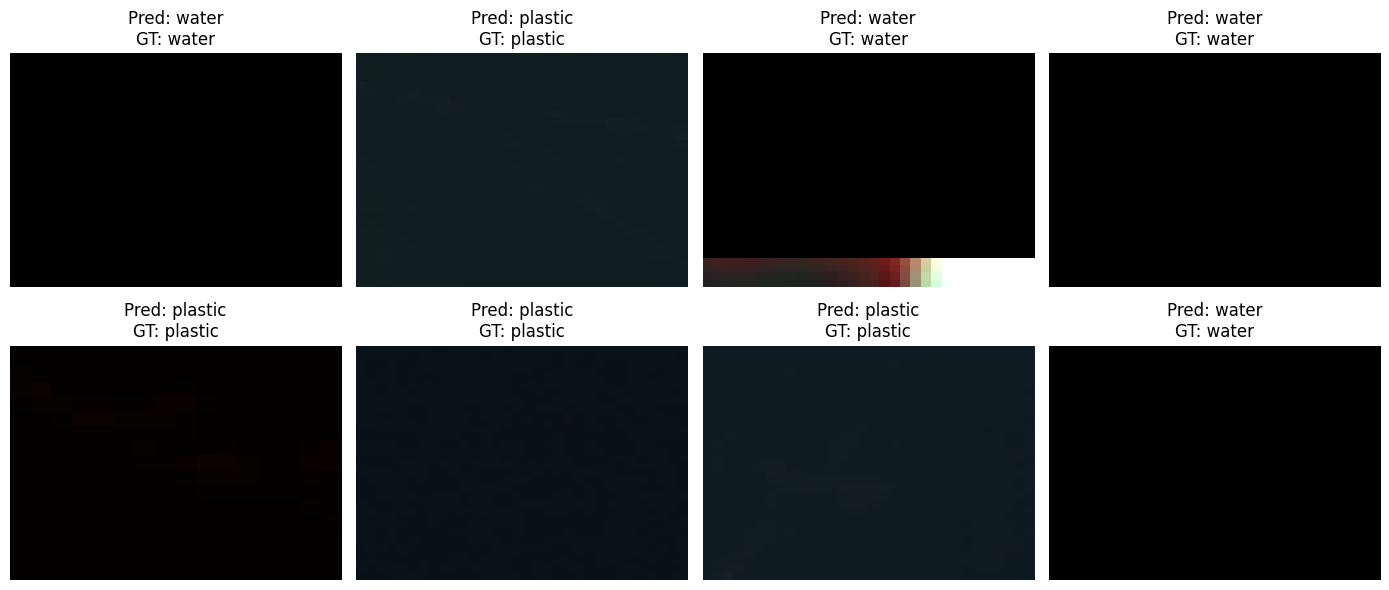

In [ ]:
import torch
import matplotlib.pyplot as plt

# Example class names (adjust if you have different labels)
class_names = ["water", "plastic"]

model.eval()  # Set model to evaluation mode

# Grab one batch of test data
images, labels = next(iter(test_loader))

# Move the batch to the same device as the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
images, labels = images.to(device), labels.to(device)

# Forward pass (no gradient calculation needed)
with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

# Convert some images back to CPU for plotting
images_cpu = images.cpu()
preds_cpu = preds.cpu()
labels_cpu = labels.cpu()

# Plot a few samples
num_samples_to_show = min(8, images_cpu.size(0))  # Show up to 8 images
plt.figure(figsize=(14, 6))

for i in range(num_samples_to_show):
    ax = plt.subplot(2, 4, i + 1)

    # If you have 12 bands, you can either select a subset (e.g., RGB bands)
    # or display a single band. Here's an example if you had 3-channel data:
    # (For 12-band images, you might adapt or omit direct visualization.)
    img = images_cpu[i]
    
    # Example: if your image is 3-channel, convert shape [C,H,W] -> [H,W,C]
    # If you truly have 12 bands, consider picking 3 representative bands:
    img = img[[3,2,1], :, :]  # e.g., first 3 bands, or any subset
    img_np = img.permute(1, 2, 0).numpy()

    plt.imshow(img_np, aspect='auto')  # Might need normalization or scaling
    plt.title(f"Pred: {class_names[preds_cpu[i].item()]}\n"
              f"GT: {class_names[labels_cpu[i].item()]}")
    plt.axis("off")

plt.tight_layout()
plt.show()


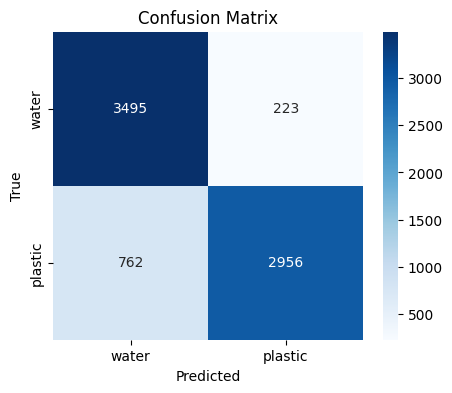

In [12]:
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        # Move preds & labels to CPU numpy arrays
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Now compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Optionally define class names (for a 2-class problem, e.g., water/plastic)
class_names = ["water", "plastic"]

# Plot using seaborn
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm, 
    annot=True,       # show numbers in cells
    fmt='d',          # integer formatting
    cmap='Blues', 
    xticklabels=class_names, 
    yticklabels=class_names
)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [10]:
# Save the model
torch.save(model, "pytorch_models/100_epochs_classweights_augmentations.pth")